In [1]:
import os
import zipfile
import shutil
from sklearn.model_selection import train_test_split
import stat

# --- CONFIGURATION ---
# Path to your ZIP file
zip_path = r"C:\Users\Lenovo LOQ\Downloads\Deep Learning Capstone\Skin.zip"
# Where to extract it
extract_dir = r"C:\Users\Lenovo LOQ\Downloads\Deep Learning Capstone\Skin"
# Where to store the train/test split version
base_dir = os.path.join(extract_dir, "dataset_split")

# --- STEP 1: UNZIP THE DATASET ---
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
print("✅ Dataset unzipped.")

# --- HANDLE FILE PERMISSIONS (for deleting folders) ---
def on_rm_error(func, path, exc_info):
    os.chmod(path, stat.S_IWRITE)
    func(path)

# --- STEP 2: PREPARE DATASET SPLIT ---
def prepare_dataset(input_dir, output_dir, train_ratio=0.8):
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir, onerror=on_rm_error)
    os.makedirs(output_dir, exist_ok=True)

    classes = [d for d in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, d))]
    print(f"📁 Found classes: {classes}")

    allowed_exts = ('.jpg', '.jpeg', '.png')

    for cls in classes:
        class_dir = os.path.join(input_dir, cls)
        images = [
            f for f in os.listdir(class_dir)
            if os.path.isfile(os.path.join(class_dir, f)) and f.lower().strip().endswith(allowed_exts)
        ]

        print(f"📸 {cls}: {len(images)} valid image(s)")

        if len(images) < 2:
            print(f"⚠️ Skipping '{cls}' — not enough images to split.")
            continue

        train_imgs, test_imgs = train_test_split(images, train_size=train_ratio, random_state=42)

        for split, img_list in zip(["train", "test"], [train_imgs, test_imgs]):
            split_dir = os.path.join(output_dir, split, cls)
            os.makedirs(split_dir, exist_ok=True)

            for img in img_list:
                src = os.path.join(class_dir, img)
                dst = os.path.join(split_dir, img)
                shutil.copy2(src, dst)

    print(f"✅ Dataset split into train/test at: {output_dir}")

# --- STEP 3: AUTO-DETECT ROOT FOLDER CONTAINING CLASSES ---
# Usually after unzipping, the image folders will be inside extract_dir directly
dataset_source = extract_dir

prepare_dataset(dataset_source, base_dir)


✅ Dataset unzipped.
📁 Found classes: ['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'dataset_split', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections']
📸 Acne and Rosacea Photos: 312 valid

In [3]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set this path to where you created your dataset_split
base_dir = r"C:\Users\Lenovo LOQ\Downloads\Deep Learning Capstone\Skin\dataset_split"

train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# Define image size expected by most pre-trained models
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# --- DATA AUGMENTATION FOR TRAINING ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# --- ONLY RESCALE TESTING IMAGES ---
test_datagen = ImageDataGenerator(rescale=1./255)

# --- LOAD TRAINING DATA ---
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # For multi-class classification
)

# --- LOAD TESTING DATA ---
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Important for evaluation
)

# Show class mappings
print("Class indices:", train_generator.class_indices)


Found 3192 images belonging to 23 classes.
Found 810 images belonging to 23 classes.
Class indices: {'Acne and Rosacea Photos': 0, 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions': 1, 'Atopic Dermatitis Photos': 2, 'Bullous Disease Photos': 3, 'Cellulitis Impetigo and other Bacterial Infections': 4, 'Eczema Photos': 5, 'Exanthems and Drug Eruptions': 6, 'Hair Loss Photos Alopecia and other Hair Diseases': 7, 'Herpes HPV and other STDs Photos': 8, 'Light Diseases and Disorders of Pigmentation': 9, 'Lupus and other Connective Tissue diseases': 10, 'Melanoma Skin Cancer Nevi and Moles': 11, 'Nail Fungus and other Nail Disease': 12, 'Poison Ivy Photos and other Contact Dermatitis': 13, 'Psoriasis pictures Lichen Planus and related diseases': 14, 'Scabies Lyme Disease and other Infestations and Bites': 15, 'Seborrheic Keratoses and other Benign Tumors': 16, 'Systemic Disease': 17, 'Tinea Ringworm Candidiasis and other Fungal Infections': 18, 'Urticaria Hives': 19, 'Vascu

In [6]:
import os
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# --- PATH CONFIGURATION ---
NUM_CLASSES = len(train_generator.class_indices)

# --- BUILDING THE MODEL ---
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True  # Fine-tuning

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# --- COMPILE MODEL ---
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# --- SET CALLBACKS ---
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# --- TRAIN THE MODEL ---
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=25,
    callbacks=[checkpoint, early_stop]
)


Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.1272 - loss: 3.2292 
Epoch 1: val_accuracy improved from -inf to 0.22099, saving model to best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 1327s 12s/step - accuracy: 0.1278 - loss: 3.2267 - val_accuracy: 0.2210 - val_loss: 2.7760
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.3223 - loss: 2.3317 
Epoch 2: val_accuracy improved from 0.22099 to 0.27531, saving model to best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 1196s 12s/step - accuracy: 0.3224 - loss: 2.3315 - val_accuracy: 0.2753 - val_loss: 2.5113
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.4188 - loss: 1.9618 
Epoch 3: val_accuracy improved from 0.27531 to 0.34321, saving model to best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 1200s 12s/step - accuracy: 0.4189 - loss: 1.9614 - val_accuracy: 0.3432 - val_loss: 2.2953
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.5131 - loss: 1.6311 
Epoch 4: val_accuracy improved from 0.34321 to 0.37654, saving model to best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 1194s 12s/step - accuracy: 0.5132 - loss: 1.6306 - val_accuracy: 0.3765 - val_loss: 2.2234
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.6124 - loss: 1.2913 
Epoch 5: val_accuracy did not improve from 0.37654
100/100 ━━━━━━━━━━━━━━━━━━━━ 1193s 12s/step - accuracy: 0.6123 - loss: 1.2915 - val_accuracy: 0.3667 - val_loss: 2.2980
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.7075 - loss: 1.0276 
Epoch 6: val_accuracy did not improve from 0.37654
100/100 ━━━━━━━━━━━━━━━━━━━━ 1193s 12s/step - accuracy: 0.7074 - loss: 1.0279 - val_accuracy: 0.3642 - val_loss: 2.2289
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.7793 - loss: 0.7753 
Epoch 7: val_accuracy did not improve from 0.37654
100/100 ━━━━━━━━━━━━━━━━━━━━ 1194s 12s/step - accuracy: 0.7792 - loss: 0.7757 - val_accuracy: 0.3704 - val_loss: 2.3938
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.8407 - loss: 0.6116 
Epoch 8: val_accura

100/100 ━━━━━━━━━━━━━━━━━━━━ 1198s 12s/step - accuracy: 0.8406 - loss: 0.6117 - val_accuracy: 0.3901 - val_loss: 2.3512
Epoch 9/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.8833 - loss: 0.4448 
Epoch 9: val_accuracy did not improve from 0.39012
100/100 ━━━━━━━━━━━━━━━━━━━━ 1195s 12s/step - accuracy: 0.8832 - loss: 0.4450 - val_accuracy: 0.3728 - val_loss: 2.5740
Epoch 10/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9148 - loss: 0.3477 
Epoch 10: val_accuracy improved from 0.39012 to 0.39259, saving model to best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 1180s 12s/step - accuracy: 0.9147 - loss: 0.3480 - val_accuracy: 0.3926 - val_loss: 2.4315
Epoch 11/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.9280 - loss: 0.2924 
Epoch 11: val_accuracy did not improve from 0.39259
100/100 ━━━━━━━━━━━━━━━━━━━━ 2319s 23s/step - accuracy: 0.9280 - loss: 0.2925 - val_accuracy: 0.3728 - val_loss: 2.7045
Epoch 12/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9454 - loss: 0.2528 
Epoch 12: val_accuracy improved from 0.39259 to 0.39383, saving model to best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 1201s 12s/step - accuracy: 0.9454 - loss: 0.2529 - val_accuracy: 0.3938 - val_loss: 2.6288
Epoch 13/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9486 - loss: 0.1996 
Epoch 13: val_accuracy improved from 0.39383 to 0.39753, saving model to best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 1188s 12s/step - accuracy: 0.9487 - loss: 0.1996 - val_accuracy: 0.3975 - val_loss: 2.8205
Epoch 14/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9706 - loss: 0.1464 
Epoch 14: val_accuracy did not improve from 0.39753
100/100 ━━━━━━━━━━━━━━━━━━━━ 1189s 12s/step - accuracy: 0.9705 - loss: 0.1466 - val_accuracy: 0.3914 - val_loss: 2.7541
Epoch 15/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9610 - loss: 0.1538 
Epoch 15: val_accuracy improved from 0.39753 to 0.40617, saving model to best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 1201s 12s/step - accuracy: 0.9610 - loss: 0.1537 - val_accuracy: 0.4062 - val_loss: 2.9382
Epoch 16/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9734 - loss: 0.1239 
Epoch 16: val_accuracy improved from 0.40617 to 0.41111, saving model to best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 1193s 12s/step - accuracy: 0.9733 - loss: 0.1241 - val_accuracy: 0.4111 - val_loss: 2.9402
Epoch 17/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9670 - loss: 0.1432 
Epoch 17: val_accuracy did not improve from 0.41111
100/100 ━━━━━━━━━━━━━━━━━━━━ 1187s 12s/step - accuracy: 0.9670 - loss: 0.1432 - val_accuracy: 0.3864 - val_loss: 3.1050
Epoch 18/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9704 - loss: 0.1119 
Epoch 18: val_accuracy did not improve from 0.41111
100/100 ━━━━━━━━━━━━━━━━━━━━ 1186s 12s/step - accuracy: 0.9704 - loss: 0.1121 - val_accuracy: 0.3926 - val_loss: 3.0886
Epoch 19/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9768 - loss: 0.0998 
Epoch 19: val_accuracy did not improve from 0.41111
100/100 ━━━━━━━━━━━━━━━━━━━━ 1183s 12s/step - accuracy: 0.9767 - loss: 0.1001 - val_accuracy: 0.3951 - val_loss: 2.9780
Epoch 20/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9769 - loss: 0.1006 
Epoch 20: va

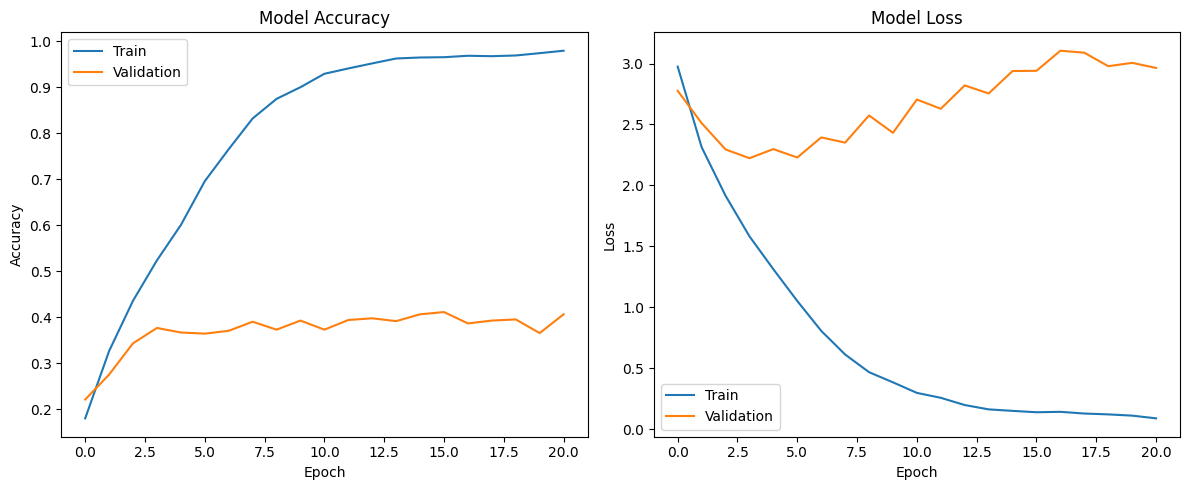

In [7]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()
